## COMP5328 - Advanced Machine Learning
## Assignment 1: Non-negative Matrix Factorization
----------------------------------------------------------------------------------------

**(Semester 2, 2020)**

In this ipython notebook, we provide some example code for assignment1.
+ Load Data.
    - ORL dataset. 
    - Extended YaleB dataset. 
    - AR dataset (**optional**).
+ Perform Evaluation. 
   - Relative Reconstruction Errors.
   - Accuracy, NMI (**optional**).

Lecturer: Tongliang Liu.

Tutors: Nicholas James, Songhua Wu, Xuefeng Li, Yu Yao.

**Note: All datasets can be used only for this assignment and you are not allowed to distribute these datasets. If you want to use AR dataset, you need to apply it by yourself (we do not provide AR dataset due to the problem of license, please find more details in http://www2.ece.ohio-state.edu/~aleix/ARdatabase.html).**

## 0. Load Modules

In [7]:
# autoreload for modules
%load_ext autoreload
%autoreload 2

# Define your functions in organised individual python files. Don't throw them randomly in the notebook

## Import image processing modules
import os
import numpy as np
import pandas as pd # Used for simpler processing of data
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt

from utils import *

## Import Algorithms
from algs import NmfHyperEstimator, NmfL2Estimator, ModifiedNMF, NmfL1Estimator

#Import preprocessing
from preprocessing import SaltNPepper, Gaussian, ImageNormalizer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Load Dataset

### 1.0 Data Folder

In [8]:
# The structure of data folder.
!ls -l data

total 0
drwxr-xr-x 41 Dovermore staff 1312 Oct  6 14:04 CroppedYaleB
drwxr-xr-x 44 Dovermore staff 1408 Oct  6 14:04 ORL


### 1.1 Load ORL Dataset and Extended YaleB Dataset.
+ ORL dataset contains ten different images of each of 40 distinct subjects. For some subjects, the images were taken at different times, varying the lighting, facial expressions (open / closed eyes, smiling / not smiling) and facial details (glasses / no glasses). All the images were taken against a dark homogeneous background with the subjects in an upright, frontal position (with tolerance for some side movement). The size of each image is 92x112 pixels, with 256 grey levels per pixel. To further reduce the computation complexity, you can resize all images to 30x37 pixels.

+ Extended YaleB dataset contains 2414 images of 38 human subjects under 9 poses and 64 illumination conditions. All images are manually aligned, cropped, and then resized to 168x192 pixels. To further reduce the computation complexity, you can resize all images to 42x48 pixels.

In [4]:
# Load Extended YaleB dataset.
X_yaleb, Y_yaleb = load_data(root='data/CroppedYaleB', reduce=4)
print('Extended YalB dataset: X.shape = {}, Y.shape = {}'.format(X_yaleb.shape, Y_yaleb.shape))

Extended YalB dataset: X.shape = (2016, 2414), Y.shape = (2414,)


In [6]:
# determine save place
try:
    save_to
except:
    save_to = check_create_dir("../run_"+get_current_time()+"/YaleB")
    image_path = save_to/"figures"
    csv_path = save_to/"tables"
    check_create_dir(image_path)
    check_create_dir(csv_path)

PosixPath('../run_10212225/YaleB/tables')

## 2. Evaluation Metrics


### 2.1 Relative Reconstruction Errors (RRE)

To compare the robustness of different NMF algorithms, you can use the ```relative reconstruction errors```. Let $V$ denote the contaminated dataset (by adding noise), and $\hat{V}$
 denote the clean dataset. Let $W$ and $H$ denote the factorization results on $V$, the ``relative reconstruction errors`` then can be defined as follows:
 \begin{equation}
    RRE = \frac{ \| \hat{V} - WH \|_F }{ \| \hat{V} \|_F}.
\end{equation}


In [9]:
#Demonstrate noisy Image
V_hat, Y_hat = load_data(root='data/CroppedYaleB', reduce=4)
scaler = ImageNormalizer(min=None, max=None)

In [10]:
noise = SaltNPepper(p=0.1, r=0.4) 

V_snp = noise.fit_transform(V_hat)
V_snp = scaler.fit_transform(V_snp)

noise_g = Gaussian(mean=0, sigma=10) 
V_g = noise_g.fit_transform(V_hat)
V_g = scaler.fit_transform(V_g)

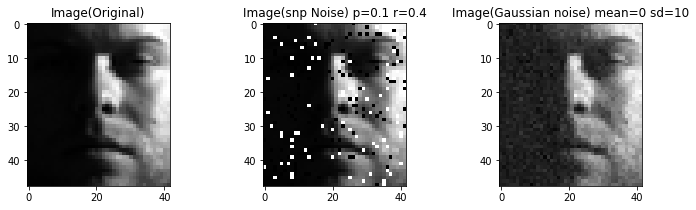

In [11]:
#Plot result.
img_size = [i//4 for i in (168, 192)]
ind = 2 # index of demo image.
plt.figure(figsize=(12,3))
plt.subplot(131)
plt.imshow(V_hat[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image(Original)')
plt.subplot(132)
plt.imshow(V_snp[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image(snp Noise) p=0.1 r=0.4')
plt.subplot(133)
plt.imshow(V_g[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image(Gaussian noise) mean=0 sd=10')
plt.draw()
plt.savefig(image_path/"noisyImage", dpi=100)
plt.show()

In [12]:
#Image Reconstruction
#Using Hypersurface
np.random.seed(0)
nmf_hyper = NmfHyperEstimator(n_components=50) # set n_components to num_classes.
#Salt n Pepper
H = nmf_hyper.fit_transform(V_snp)
W = nmf_hyper.components_
V_snp_reconstructed_hyper = W @ H
#Gaussian
H = nmf_hyper.fit_transform(V_g)
V_g_reconstructed_hyper = W @ H

#Using L2NMF
np.random.seed(0)
nmf_L2 = NmfL2Estimator(n_components=50) # set n_components to num_classes.
#SaltNPepper
H = nmf_L2.fit_transform(V_snp)
W = nmf_L2.components_
V_snp_reconstructed_L2 = W @ H
#Gaussian
H = nmf_L2.fit_transform(V_g)
V_g_reconstructed_L2 = W @ H

#Using L1NMF
np.random.seed(0)
nmf_L1 = NmfL1Estimator(n_components=50) # set n_components to num_classes.
#SaltNPepper
H = nmf_L1.fit_transform(V_snp)
W = nmf_L1.components_
V_snp_reconstructed_L1 = W @ H
#Gaussian
H = nmf_L1.fit_transform(V_g)
V_g_reconstructed_L1 = W @ H

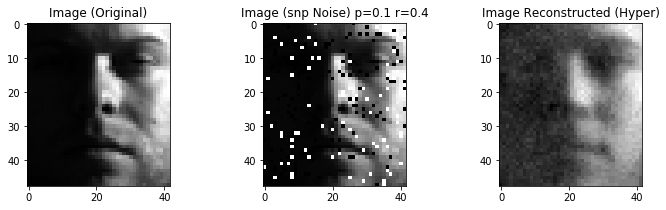

In [13]:
#Reconstruction (snp noise) using hyper
img_size = [i//4 for i in (168, 192)]
ind = 2 # index of demo image.
plt.figure(figsize=(12,3))
plt.subplot(131)
plt.imshow(V_hat[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image (Original)')
plt.subplot(132)
plt.imshow(V_snp[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image (snp Noise) p=0.1 r=0.4')
plt.subplot(133)
plt.imshow(V_snp_reconstructed_hyper[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image Reconstructed (Hyper)')
plt.savefig(image_path/"reconstructedHyper_snp.png", dpi=100)

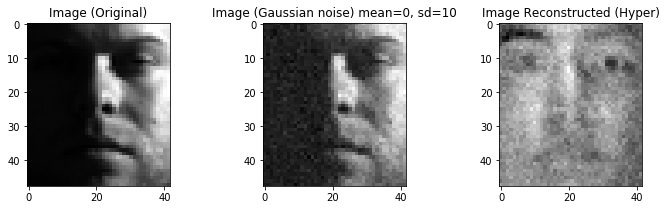

In [14]:
#Reconstruction (Gaussian noise) using hyper
img_size = [i//4 for i in (168, 192)]
ind = 2 # index of demo image.
plt.figure(figsize=(12,3))
plt.subplot(131)
plt.imshow(V_hat[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image (Original)')
plt.subplot(132)
plt.imshow(V_g[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image (Gaussian noise) mean=0, sd=10')
plt.subplot(133)
plt.imshow(V_g_reconstructed_hyper[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image Reconstructed (Hyper)')
plt.savefig(image_path/"reconstructedHyper_gaussian", dpi=100)

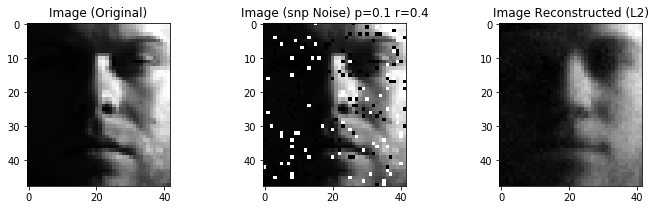

In [15]:
#Reconstruction (snp noise) using L2NMF
img_size = [i//4 for i in (168, 192)]
ind = 2 # index of demo image.
plt.figure(figsize=(12, 3))
plt.subplot(131)
plt.imshow(V_hat[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image (Original)')
plt.subplot(132)
plt.imshow(V_snp[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image (snp Noise) p=0.1 r=0.4')
plt.subplot(133)
plt.imshow(V_snp_reconstructed_L2[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image Reconstructed (L2)')
plt.savefig(image_path/"reconstructedL2_snp", dpi=100)

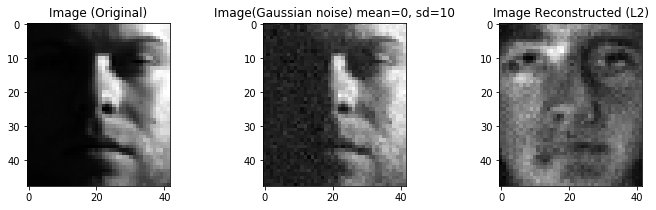

In [16]:
#Reconstruction (Gaussian noise) using L2NMF
img_size = [i//4 for i in (168, 192)]
ind = 2 # index of demo image.
plt.figure(figsize=(12, 3))
plt.subplot(131)
plt.imshow(V_hat[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image (Original)')
plt.subplot(132)
plt.imshow(V_g[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image(Gaussian noise) mean=0, sd=10')
plt.subplot(133)
plt.imshow(V_g_reconstructed_L2[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image Reconstructed (L2)')
plt.savefig(image_path/"reconstructedL2_gaussian", dpi=100)

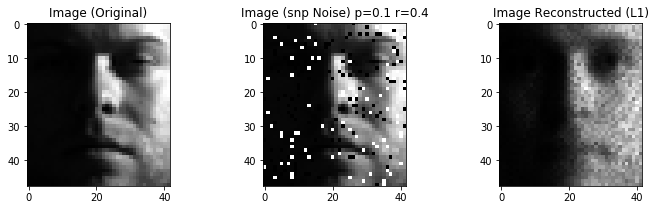

In [17]:
#Reconstruction (snp noise) using L1NMF
img_size = [i//4 for i in (168, 192)]
ind = 2 # index of demo image.
plt.figure(figsize=(12, 3))
plt.subplot(131)
plt.imshow(V_hat[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image (Original)')
plt.subplot(132)
plt.imshow(V_snp[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image (snp Noise) p=0.1 r=0.4')
plt.subplot(133)
plt.imshow(V_snp_reconstructed_L1[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image Reconstructed (L1)')
plt.savefig(image_path/"reconstructedL1_snp", dpi=100)

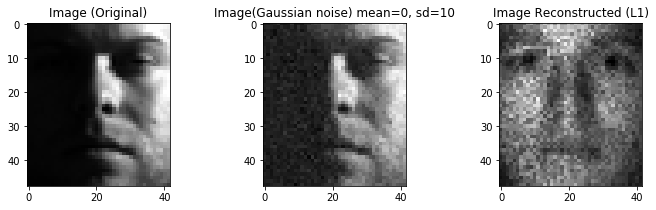

In [18]:
#Reconstruction (Gaussian noise) using L2NMF
img_size = [i//4 for i in (168, 192)]
ind = 2 # index of demo image.
plt.figure(figsize=(12, 3))
plt.subplot(131)
plt.imshow(V_hat[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image (Original)')
plt.subplot(132)
plt.imshow(V_g[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image(Gaussian noise) mean=0, sd=10')
plt.subplot(133)
plt.imshow(V_g_reconstructed_L1[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image Reconstructed (L1)')
plt.savefig(image_path/"reconstructedL1_gaussian", dpi=100)

### 2.2 Evaluate Clustering Performance

1. Accuracy.
    
    $$ Acc(Y, Y_{pred}) = \frac{1}{n}\sum\limits_{i=1}^n 1\{Y_{pred}(i) == Y(i)\}$$
        
2. Normalized Mutual Information (NMI).

    $$ NMI(Y, Y_{pred}) = \frac{2 * I(Y, Y_{pred})}{H(Y) + H(Y_{pred})} $$
    
   where $ I(\cdot,\cdot) $ is mutual information and $ H(\cdot) $ is entropy.

## Performance comparison using Salt and Pepper noise (with scaling) with 90% samples (3 shuffles)

In [53]:
X, Y, scaler = X_yaleb, Y_yaleb, ImageNormalizer(min=None,max=None)

alg_kwargs_pairs = [
    ModifiedNMF, 
    NmfL2Estimator, 
    NmfHyperEstimator,
    NmfL1Estimator
]

metrics = [rre_score, acc_score, nmi_score]
metrics_names = ["rre", "acc_score", "nmi_score"]
n_trials = 10
pc_sample = 0.9

#Saltnpepper noise
all_n_components = [50]
noise_alg = SaltNPepper
noise_levels = np.arange(0, 0.7, 0.1)
ratios = [0.5] #np.arange(0.0, 1, 0.5)
noise_kwargs_pairs = make_grid_alg_kwargs(noise_alg, p=noise_levels, r=ratios)

evaluations_snp = benchmark(X_yaleb, Y_yaleb, scaler,
                        alg_kwargs_pairs, all_n_components,
                        noise_kwargs_pairs,
                        metrics, metrics_names,
                        n_trials, pc_sample
                       )

Noise: {'noise_id': 0, 'p': 0.0, 'r': 0.5}
    Trail: 0
        Alg: ModifiedNMF {}
        Alg: NmfL2Estimator {}
        Alg: NmfHyperEstimator {}
        Alg: NmfL1Estimator {}
    Trail: 1
        Alg: ModifiedNMF {}
        Alg: NmfL2Estimator {}
        Alg: NmfHyperEstimator {}
        Alg: NmfL1Estimator {}
    Trail: 2
        Alg: ModifiedNMF {}
        Alg: NmfL2Estimator {}
        Alg: NmfHyperEstimator {}
        Alg: NmfL1Estimator {}
    Trail: 3
        Alg: ModifiedNMF {}
        Alg: NmfL2Estimator {}
        Alg: NmfHyperEstimator {}
        Alg: NmfL1Estimator {}
    Trail: 4
        Alg: ModifiedNMF {}
        Alg: NmfL2Estimator {}
        Alg: NmfHyperEstimator {}
        Alg: NmfL1Estimator {}
    Trail: 5
        Alg: ModifiedNMF {}
        Alg: NmfL2Estimator {}
        Alg: NmfHyperEstimator {}
        Alg: NmfL1Estimator {}
    Trail: 6
        Alg: ModifiedNMF {}
        Alg: NmfL2Estimator {}
        Alg: NmfHyperEstimator {}
        Alg: NmfL1Estimator {

In [54]:
evaluations_snp.to_csv(csv_path/'raw_snp_scaled_90%.csv')
evaluations_snp_mean = evaluations_snp.groupby(['alg','n_components','noise_id']).mean()
evaluations_snp_mean = evaluations_snp_mean.rename(columns={'rre':'rre_mean','acc_score':'acc_mean','nmi_score':'nmi_mean'})
evaluations_snp_std = evaluations_snp.groupby(['alg','n_components','noise_id']).std()
evaluations_snp_std = evaluations_snp_std.rename(columns={'rre':'rre_sd','acc_score':'acc_sd','nmi_score':'nmi_sd'})
evaluations_snp_std = evaluations_snp_std.drop(columns=['p', 'r'])
evaluations_snp_grouped = pd.concat([evaluations_snp_mean, evaluations_snp_std],axis=1)
evaluations_snp_grouped.to_csv(csv_path/'Performance_snp_scaled_90%.csv')
evaluations_snp_grouped_idxreset = evaluations_snp_grouped.reset_index()

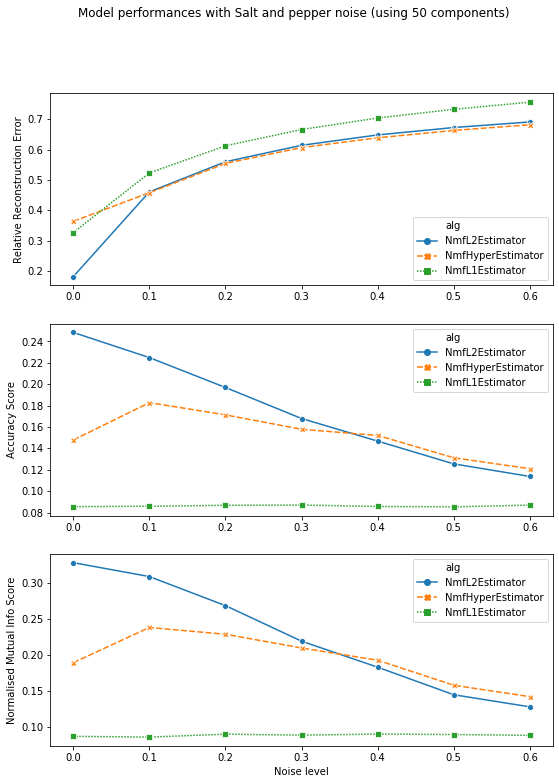

In [59]:
# Plotting RRE, Accuracy and NMI scores against different Salt & pepper noise levels for n_components=50
fig = plt.figure(figsize=[9, 12])

ax = fig.add_subplot(311)
sns.lineplot(
    x="p",
    #y="rre_mean",
    y="rre",
    hue="alg",
    #size="n_components",
    style="alg",
    #data=evaluations_snp_grouped_idxreset.query("n_components == 50 and (alg=='NmfL2Estimator' or alg=='NmfHyperEstimator' or alg=='NmfL1Estimator')"),
    data=evaluations_snp.query("n_components == 50 and (alg=='NmfL2Estimator' or alg=='NmfHyperEstimator' or alg=='NmfL1Estimator')"),
    #ci=95,
    ci=None,
    n_boot=1000,
    markers=True,
    seed=None,
    sort=True,
    err_style='band',
    #legend='full',
)
ax.set_xlabel('')
ax.set_ylabel("Relative Reconstruction Error")
#ax.legend(title="Algorithm", loc="upper left", labels=['NMF (sklearn)','L2-NMF','Hypersurface'])

ax = fig.add_subplot(312)
sns.lineplot(
    x="p",
    #y="acc_mean",
    y="acc_score",
    hue="alg",
    #size="n_components",
    style="alg",
    #data=evaluations_snp_grouped_idxreset.query("n_components == 50 and (alg=='NmfL2Estimator' or alg=='NmfHyperEstimator' or alg=='NmfL1Estimator')"),
    data=evaluations_snp.query("n_components == 50 and (alg=='NmfL2Estimator' or alg=='NmfHyperEstimator' or alg=='NmfL1Estimator')"),
    #ci=95,
    ci=None,
    n_boot=1000,
    markers=True,
    seed=None,
    sort=True,
    err_style='band',
    legend='full',
)
ax.set_xlabel('')
ax.set_ylabel("Accuracy Score")
#ax.legend(title="Algorithm", loc="upper right", labels=['NMF (sklearn)','L2-NMF','Hypersurface'])

ax = fig.add_subplot(313)
sns.lineplot(
    x="p",
    #y="nmi_mean",
    y="nmi_score",
    hue="alg",
    #size="n_components",
    style="alg",
    #data=evaluations_snp_grouped_idxreset.query("n_components == 50 and (alg=='NmfL2Estimator' or alg=='NmfHyperEstimator' or alg=='NmfL1Estimator')"),
    data=evaluations_snp.query("n_components == 50 and (alg=='NmfL2Estimator' or alg=='NmfHyperEstimator' or alg=='NmfL1Estimator')"),
    #ci=95,
    ci=None,
    markers=True,
    n_boot=1000,
    seed=None,
    sort=True,
    err_style='band',
    legend='full',
)
ax.set_xlabel("Noise level")
ax.set_ylabel("Normalised Mutual Info Score")
#ax.legend(title="Algorithm", loc="upper right", labels=['NMF (sklearn)','L2-NMF','Hypersurface'])
plt.suptitle("Model performances with Salt and pepper noise (using 50 components)")
plt.savefig(image_path/"snp_scaled_90%")

## Model performance on Gaussian noise

In [56]:
# Gaussian noise
noise_alg = Gaussian
means = [0]
sigmas = list(range(0, 50, 5))
noise_kwargs_pairs = make_grid_alg_kwargs(noise_alg, mean=means, sigma=sigmas)

evaluations_g = benchmark(X_yaleb, Y_yaleb, scaler,
                          alg_kwargs_pairs, all_n_components,
                          noise_kwargs_pairs,
                          metrics, metrics_names,
                          n_trials, pc_sample
                         )  

Noise: {'noise_id': 0, 'mean': 0, 'sigma': 0}
    Trail: 0
        Alg: ModifiedNMF {}
        Alg: NmfL2Estimator {}
        Alg: NmfHyperEstimator {}
        Alg: NmfL1Estimator {}
    Trail: 1
        Alg: ModifiedNMF {}
        Alg: NmfL2Estimator {}
        Alg: NmfHyperEstimator {}
        Alg: NmfL1Estimator {}
    Trail: 2
        Alg: ModifiedNMF {}
        Alg: NmfL2Estimator {}
        Alg: NmfHyperEstimator {}
        Alg: NmfL1Estimator {}
    Trail: 3
        Alg: ModifiedNMF {}
        Alg: NmfL2Estimator {}
        Alg: NmfHyperEstimator {}
        Alg: NmfL1Estimator {}
    Trail: 4
        Alg: ModifiedNMF {}
        Alg: NmfL2Estimator {}
        Alg: NmfHyperEstimator {}
        Alg: NmfL1Estimator {}
    Trail: 5
        Alg: ModifiedNMF {}
        Alg: NmfL2Estimator {}
        Alg: NmfHyperEstimator {}
        Alg: NmfL1Estimator {}
    Trail: 6
        Alg: ModifiedNMF {}
        Alg: NmfL2Estimator {}
        Alg: NmfHyperEstimator {}
        Alg: NmfL1Estimato

In [57]:
evaluations_g.to_csv(csv_path/'raw_g_scaled_90%.csv')
evaluations_g_mean = evaluations_g.groupby(['alg','n_components','noise_id']).mean()
evaluations_g_mean = evaluations_g_mean.rename(columns={'rre':'rre_mean','acc_score':'acc_mean','nmi_score':'nmi_mean'})
evaluations_g_std = evaluations_g.groupby(['alg','n_components','noise_id']).std()
evaluations_g_std = evaluations_g_std.rename(columns={'rre':'rre_sd','acc_score':'acc_sd','nmi_score':'nmi_sd'})
evaluations_g_std = evaluations_g_std.drop(columns=['mean', 'sigma'])
evaluations_g_grouped = pd.concat([evaluations_g_mean, evaluations_g_std],axis=1)
evaluations_g_grouped.to_csv(csv_path/'Performance_g_scaled_90%.csv')
evaluations_g_grouped_idxreset = evaluations_g_grouped.reset_index()

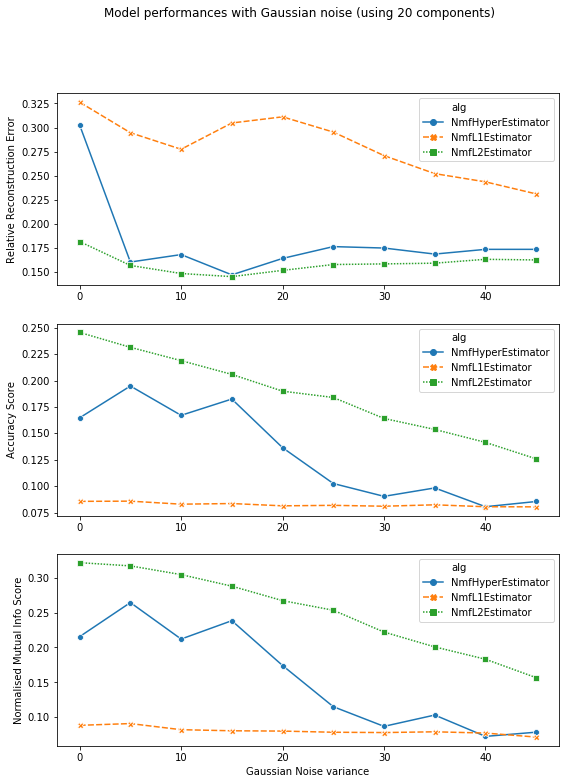

In [58]:
# Plotting RRE, Accuracy and NMI scores against different Gaussian noises for n_components=50
fig = plt.figure(figsize=[9, 12])

ax = fig.add_subplot(311)
sns.lineplot(
    x="sigma",
    y="rre_mean",
    hue="alg",
    #size="n_components",
    style="alg",
    data=evaluations_g_grouped_idxreset.query("alg=='NmfL2Estimator' or alg=='NmfHyperEstimator' or alg=='NmfL1Estimator'"),
    estimator='mean',
    ci=95,
    n_boot=1000,
    markers=True,
    seed=None,
    sort=True,
    err_style='band',
    #legend='full',
)
ax.set_xlabel('')
ax.set_ylabel("Relative Reconstruction Error")
#ax.legend(title="Algorithm", loc="upper left", labels=['NMF (sklearn)','L2-NMF','Hypersurface'])

ax = fig.add_subplot(312)
sns.lineplot(
    x="sigma",
    y="acc_mean",
    hue="alg",
    #size="n_components",
    style="alg",
    data=evaluations_g_grouped_idxreset.query("alg=='NmfL2Estimator' or alg=='NmfHyperEstimator' or alg=='NmfL1Estimator'"),
    estimator='mean',
    ci=95,
    n_boot=1000,
    markers=True,
    seed=None,
    sort=True,
    err_style='band',
    legend='full',
)
ax.set_xlabel('')
ax.set_ylabel("Accuracy Score")
#ax.legend(title="Algorithm", loc="upper right", labels=['NMF (sklearn)','L2-NMF','Hypersurface'])

ax = fig.add_subplot(313)
sns.lineplot(
    x="sigma",
    y="nmi_mean",
    hue="alg",
    #size="n_components",
    style="alg",
    data=evaluations_g_grouped_idxreset.query("alg=='NmfL2Estimator' or alg=='NmfHyperEstimator' or alg=='NmfL1Estimator'"),
    estimator='mean',
    ci=95,
    markers=True,
    n_boot=1000,
    seed=None,
    sort=True,
    err_style='band',
    legend='full',
)
ax.set_xlabel("Gaussian Noise variance")
ax.set_ylabel("Normalised Mutual Info Score")
#ax.legend(title="Algorithm", loc="upper right", labels=['NMF (sklearn)','L2-NMF','Hypersurface'])
plt.suptitle("Model performances with Gaussian noise (using 20 components)")
plt.savefig(image_path/"Gaussian_scaled_90%")